In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import root_mean_squared_error
import cvxpy as cp
from hyperopt import fmin, tpe, hp, Trials
import matplotlib.pyplot as plt
import seaborn as sns
import data_generator as dg

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [60]:
# data generator - need to use adstock and saturation functions

# scale y and change saturation lamda
# ad max adstock lag in timesteps
# MLFlow

# validate model

# response curves

# calibration

# budget optimisation

# Data generator

In [ ]:
np.random.seed(10)

# Set parameters for data generator
start_date = "2021-01-01"
periods = 52 * 3
channels = ["tv", "social", "search"]
adstock_alphas = [0.50, 0.25, 0.05]
saturation_lamdas = [1.5, 2.5, 3.5]
betas = [350, 150, 50]
spend_scalars = [10, 15, 20]

df = dg.data_generator(start_date, periods, channels, spend_scalars, adstock_alphas, saturation_lamdas, betas)

# Scale betas using maximum sales value - this is so it is comparable to the fitted beta from pymc (pymc does feature and target scaling using MaxAbsScaler from sklearn)
betas_scaled = [
    ((df["tv_sales"] / df["sales"].max()) / df["tv_saturated"]).mean(),
    ((df["social_sales"] / df["sales"].max()) / df["social_saturated"]).mean(),
    ((df["search_sales"] / df["sales"].max()) / df["search_saturated"]).mean()
]

# Calculate contributions
contributions = np.asarray([
    round((df["tv_sales"].sum() / df["sales"].sum()), 2),
    round((df["social_sales"].sum() / df["sales"].sum()), 2),
    round((df["search_sales"].sum() / df["sales"].sum()), 2),
    round((df["demand"].sum() / df["sales"].sum()), 2)
])

df[["date", "demand", "demand_proxy", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]]

In [63]:
# set date column
date_col = "week_ending"

# set features
features = ["spend_ppc_nb",
            "spend_social",
            "demand",
]

# set target
target = "conversions"

# retrieve features and target
X = df[features].values
y = df[target].values

# Pre-processing

### Train/test indexs

In [68]:
# set train/test params
burn_in_obs = 4
out_of_time_obs = 8

# calculate indexs
train_idx = slice(burn_in_obs, len(df) - out_of_time_obs)
out_of_time_idx = slice(len(df) - out_of_time_obs, len(df))

### Set coefficient signs

In [69]:
# set coefficient upper and lower bounds
lower_bounds = [None, 0, 0, 0, 0, 0]
upper_bounds = [None, None, None, None, None, None]

# Transformations

### Carryover

In [70]:
def transform_adstock(X, adstock_decays):
    adstock_decays = np.asarray(adstock_decays)
    adstocked = np.zeros_like(X)
    adstocked[0, :] = X[0, :]
    for t in range(1, X.shape[0]):
        adstocked[t, :] = X[t, :] + adstock_decays * adstocked[t - 1, :]
    return adstocked

### Saturation

In [71]:
def transform_logistic(X, logistic_lams):
    logistic_lams = np.asarray(logistic_lams)
    return (1 - np.exp(-logistic_lams * X)) / (1 + np.exp(-logistic_lams * X))

### Scale features

In [119]:
def fit_feature_scaler(X):
    return MaxAbsScaler().fit(X)

In [120]:
def apply_feature_scaler(transformer, X):  
    return transformer.transform(X)

### Add intercept

In [74]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.hstack((intercept, X))

# Train model

### Train model

In [76]:
def train_model(X, y, reg_alpha, lower_bounds, upper_bounds):
    
    coef = cp.Variable(X.shape[1])
    ridge_penalty = cp.norm(coef, 2)
    objective = cp.Minimize(cp.sum_squares(X @ coef - y) + reg_alpha * ridge_penalty)
    
    constraints = (
    [coef[i] >= lower_bounds[i] for i in range(X.shape[1]) if lower_bounds[i] is not None] +
    [coef[i] <= upper_bounds[i] for i in range(X.shape[1]) if upper_bounds[i] is not None]
    )

    problem = cp.Problem(objective, constraints)
    problem.solve()
    print(problem.status)
    
    return coef.value

In [77]:
def predict(X, optimized_coef):
    return X @ optimized_coef

In [78]:
def rmse(y_true, y_pred):
    return round(root_mean_squared_error(y_true, y_pred), 2)

### Hyper-parameter tuning

In [129]:
def objective(params):
    
    X_adstocked = transform_adstock(X=X,
                                    adstock_decays=[params[f"adstock_decay_{i}"] for i in range(X.shape[1])])
    
    X_saturated = transform_logistic(X=X_adstocked,
                                     logistic_lams=[params[f"logistic_lam_{i}"] for i in range(X.shape[1])])                                     
    
    X_train = X_saturated[train_idx]
    X_transformer = fit_feature_scaler(X_train)
    X_train_scaled = apply_feature_scaler(X_transformer, X_train)
    X_train_scaled_intercept = add_intercept(X_train_scaled)    

    y_train = y[train_idx]
#    y_transformer = fit_feature_scaler(y_train.reshape(-1, 1))
#    y_train_scaled = apply_feature_scaler(y_transformer, y_train.reshape(-1, 1))
    
    X_transformer = fit_feature_scaler(X_train)
    X_train_scaled = apply_feature_scaler(X_transformer, X_train)
    X_train_scaled_intercept = add_intercept(X_train_scaled)
    
    optimized_coef = train_model(X=X_train_scaled_intercept, 
                                 y=y_train, 
                                 reg_alpha=params["reg_alpha"], 
                                 lower_bounds=lower_bounds, 
                                 upper_bounds=upper_bounds)
    
    train_predictions = predict(X_train_scaled_intercept, optimized_coef)
    train_rmse = rmse(y_train, train_predictions)
    
    return train_rmse

space = {
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    
    'adstock_decay_0': hp.uniform('adstock_decay_0', 0.0, 0.1),
    'adstock_decay_1': hp.uniform('adstock_decay_1', 0.0, 0.1),
    'adstock_decay_2': hp.uniform('adstock_decay_2', 0.0, 0.1),
    'adstock_decay_3': hp.uniform('adstock_decay_3', 0.0, 0.1),
    'adstock_decay_4': hp.uniform('adstock_decay_4', 0.0, 0.1),

    'logistic_lam_0': hp.uniform('logistic_lam_0', 1e-6, 1e-3),
    'logistic_lam_1': hp.uniform('logistic_lam_1', 1e-6, 1e-3),
    'logistic_lam_2': hp.uniform('logistic_lam_2', 1e-6, 1e-3),
    'logistic_lam_3': hp.uniform('logistic_lam_3', 1e-6, 1e-3),
    'logistic_lam_4': hp.uniform('logistic_lam_4', 1e-6, 1e-3),

}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

print("Best parameters found: ", best)

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

optimal                                                
optimal                                                
optimal                                                             
optimal                                                             
optimal                                                             
optimal                                                             
optimal                                                             
optimal                                                             
optimal                                                             
optimal                                                              
optimal                                                              
optimal                                                               
optimal                                                               
optimal                                                               
optimal                                             

### Final model

In [89]:
best

{'adstock_decay_0': 0.0416206519086783,
 'adstock_decay_1': 0.057198735864877316,
 'adstock_decay_2': 0.014171880716065932,
 'adstock_decay_3': 5.468419131546536e-05,
 'adstock_decay_4': 0.0018585920406338084,
 'logistic_lam_0': 1.4561269194606524e-06,
 'logistic_lam_1': 1.6997888188775682e-06,
 'logistic_lam_2': 0.0008025929963193943,
 'logistic_lam_3': 0.0007883614048612836,
 'logistic_lam_4': 0.0004434182973376934,
 'reg_alpha': 0.11703477892839252}

In [90]:
adstock_decays = np.asarray([best[f"adstock_decay_{i}"] for i in range(X.shape[1])])
logistic_lams = np.asarray([best[f"logistic_lam_{i}"] for i in range(X.shape[1])])

X_adstocked = transform_adstock(X=X, adstock_decays=adstock_decays)
    
X_saturated = transform_logistic(X=X_adstocked, logistic_lams=logistic_lams)
    
X_train = X_saturated[train_idx]
X_test = X_saturated[out_of_time_idx]
y_train = y[train_idx]
y_test = y[out_of_time_idx]
    
transformer = fit_feature_scaler(X_train)
X_train_scaled = apply_feature_scaler(transformer, X_train)
X_test_scaled = apply_feature_scaler(transformer, X_test)
    
X_train_scaled_intercept = add_intercept(X_train_scaled)
X_test_scaled_intercept = add_intercept(X_test_scaled)
    
optimized_coef = train_model(X=X_train_scaled_intercept, 
                             y=y_train, 
                             reg_alpha=best["reg_alpha"], 
                             lower_bounds=lower_bounds, 
                             upper_bounds=upper_bounds)

optimal


# Validate model

### Model fit

In [91]:
train_predictions = predict(X_train_scaled_intercept, optimized_coef)
test_predictions = predict(X_test_scaled_intercept, optimized_coef)
train_rmse = rmse(y_train, train_predictions)
test_rmse = rmse(y_test, test_predictions)

In [83]:
# actual vs predicted chart including model fit metrics

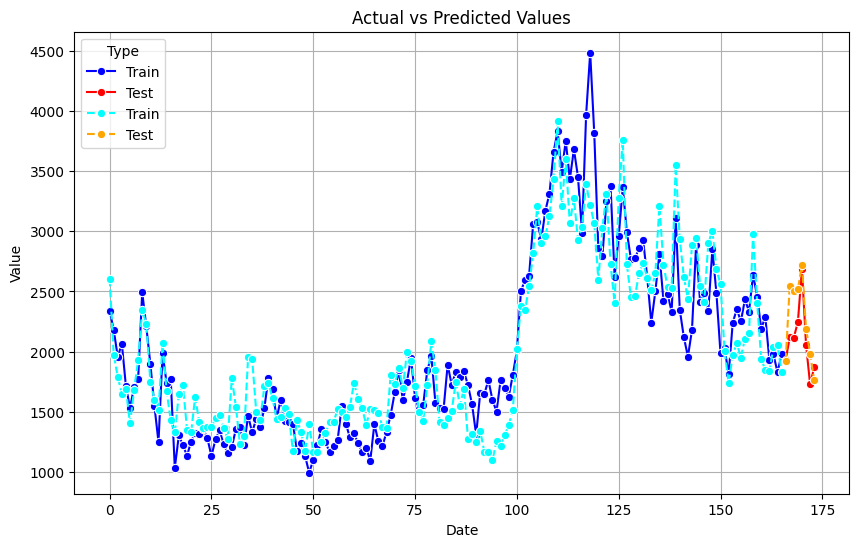

In [92]:
df_train = pd.DataFrame({
    'Actual': y_train,
    'Predicted': train_predictions,
    'Type': 'Train'
})

df_test = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Type': 'Test'
})

df = pd.concat([df_train, df_test])
df["Index"] = range(len(df))

# Plot using seaborn
plt.figure(figsize=(10, 6))

# Plot actual values
sns.lineplot(x='Index', y='Actual', hue='Type', data=df, marker='o', palette={'Train': 'blue', 'Test': 'red'})

# Plot predicted values
sns.lineplot(x='Index', y='Predicted', hue='Type', data=df, linestyle='--', marker='o', palette={'Train': 'cyan', 'Test': 'orange'})

# Formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend(title='Type', loc='upper left')
plt.grid(True)
plt.show()

### Model diagnostics

In [85]:
# look at pymc marketing

### Feature contributions

In [93]:
def calculate_contributions(X, optimized_coef):
    return X * optimized_coef.reshape(1, -1)

In [94]:
train_contributions = calculate_contributions(X_train_scaled_intercept, optimized_coef)

In [96]:
print(f'Intercept: {round(train_contributions[:, 0].sum() / train_predictions.sum(), 2)}')
print(f'Feature 1: {round(train_contributions[:, 1].sum() / train_predictions.sum(), 2)}')
print(f'Feature 2: {round(train_contributions[:, 2].sum() / train_predictions.sum(), 2)}')
print(f'Feature 3: {round(train_contributions[:, 3].sum() / train_predictions.sum(), 2)}')

Intercept: -0.17
Feature 1: 0.15
Feature 2: 0.41
Feature 3: 0.61


In [30]:
# contribution waterfall

In [31]:
# stack chart of contributions over time

# Response curves

### x

In [97]:
print(adstock_decays)
print(logistic_lams)
print(optimized_coef)

[0.04162065 0.05719874 0.01417188]
[1.45612692e-06 1.69978882e-06 8.02592996e-04]
[-334.98559174 1430.81803201 1828.01731856 1577.74742682]


In [33]:
# create range of spend values from 0 to max spend on channel * 1.2
# each spend value needs transforming (adstock, saturation, feature scaling) and the contribution calculating
# that should give what is needed for the plot
# a second plot where % of budget is on the x-axis would be great too (like from pymc)

In [98]:
np.sum(transform_adstock(np.array([[100], [0], [0]]), [0.1]))

111

# Calibration

### x

# Budget optimisation

### x